In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from scipy import stats
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math

from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

# select the style from fivethityeight website
plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['axes.labelsize'] = 14
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

# predefined figsize
figsize=(12,9)

np.random.seed(238746)

plt.style.use('seaborn-dark-palette')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal



#1608 da escludere always

# settings
import warnings
warnings.filterwarnings("ignore")

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def split_date(X,y,date):
    X_te = X[date:]
    y_te = y[date:]
    X_tr = X[:date]
    y_tr = y[:date]
    return X_tr, X_te, y_tr, y_te 

def plot_results(ytrue, prediction, label):
    df_ytrue = pd.DataFrame(ytrue)
    df_ytrue['predicted'] =  prediction #0.1*pred_test +0.2*pred_test_cat + 0.7*pred_test_xgb
    plt.plot(df_ytrue[label],label='data')
    plt.plot(df_ytrue['predicted'],label='predicted')
    #plt.ylim([200,330])
    plt.xticks(rotation=45)
    mape = mean_absolute_percentage_error(df_ytrue[label],df_ytrue['predicted'])

    plt.title("Forecasting on Test Set MAPE=%.3f"%mape)
    plt.legend();
    plt.show()


In [2]:
def create_features(df, label=None):
    
    
    #df['log_target'] = np.log(df['target']) 
    #df["logt-1"] = np.log(df["sales w-1"])
    df2 = pd.DataFrame(columns= df.columns)

    for sku in df['sku'].unique():
        sales_sku = df.loc[df['sku'] == sku]
    #sales_sku = sales.set_index(['Week'])
        sales_sku['diff1'] = -(sales_sku['sales w-1'] - sales_sku['sales w-1'].shift(1))
        sales_sku['diff2'] = -(sales_sku['sales w-1'] - sales_sku['sales w-1'].shift(2))
        sales_sku['diff3'] = -(sales_sku['sales w-1'] - sales_sku['sales w-1'].shift(3))
        sales_sku['pdiff1'] = -(sales_sku['sales w-1'] - sales_sku['sales w-1'].shift(1))/sales_sku['sales w-1']
        #sales_sku['price_pdiff1'] = -(sales_sku['price'] - sales_sku['price'].shift(1))/sales_sku['price']

        
        df2 = pd.concat((df2, sales_sku), axis = 0)

    df = df2
    #df["zdiff1"] = stats.zscore(df["diff1"])
    
    #df = df.set_index("Week")
 
    #df['date'] = df.index
    df["log_price"] = np.log(df["price"])
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear/7
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df["promo"] = df["volume_on_promo w-1"]
    df['log_diff1'] = np.log(df['diff1'])
    df['log_sales'] = np.log(df['sales w-1'])
    
    df["rolling2"] = df["sales w-1"].rolling(3).mean()

    df["rolling3"] = df["sales w-1"].rolling(2).mean()
    df["sku"] = df["sku"].apply(lambda x: int(x))
    
    #df = df.dropna()

    df = df.set_index("date")

    X = df[['quarter','month','year',"sales w-1",
           'dayofyear','dayofmonth','weekofyear',#"log_sales","log_diff1",
            'promo','diff1','diff2','pdiff1','log_price',"rolling2","rolling3","sku"]]
    
    if label:
        y = df[label]
        return X, y
    return X

In [3]:
# Read train and test files
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/x_test.csv')

train_df = train_df.drop(["target"],axis = 1)

all_df = pd.concat([train_df,test_df])



#test_df = test_df.rename({"Unnamed: 0":"Week"}, axis=1)
#train_df= train_df.rename({"Unnamed: 0":"Week"}, axis=1)
#test_df.Week = test_df.Week.apply(lambda x:datetime.strptime(x[3:], '%d %B %Y'))
#train_df.Week = train_df.Week.apply(lambda x:datetime.strptime(x[3:], '%d %B %Y'))
all_df = all_df.rename({"Unnamed: 0":"date"}, axis=1).dropna()
all_df = all_df.loc[all_df["scope"] == 1]
all_df = all_df.drop(["scope"],axis = 1)

all_df.date = all_df.date.apply(lambda x:datetime.strptime(x[3:], '%d %B %Y'))
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1884 entries, 134 to 299
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1884 non-null   datetime64[ns]
 1   sku                  1884 non-null   int64         
 2   pack                 1884 non-null   object        
 3   size (GM)            1884 non-null   float64       
 4   brand                1884 non-null   object        
 5   price                1884 non-null   float64       
 6   POS_exposed w-1      1884 non-null   float64       
 7   volume_on_promo w-1  1884 non-null   float64       
 8   sales w-1            1884 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 147.2+ KB


In [4]:
#crea la colonna target 
t2 = pd.DataFrame(columns= all_df.columns)
for sku in all_df['sku'].unique():
    sales_sku = all_df.loc[all_df['sku'] == sku]
    #sales_sku = sales.set_index(['Week'])
    sales_sku['target'] = sales_sku["sales w-1"].shift(-1)
    sales_sku = sales_sku[:-1]
    t2 = pd.concat((t2, sales_sku), axis = 0)

#t2 = t2.loc[t2["sku"] == 554]
t2 = t2.loc[np.isin(t2["sku"],[1065])]#,554,1206,1058,549,688])]
t2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 2262 to 198
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 156 non-null    datetime64[ns]
 1   sku                  156 non-null    object        
 2   pack                 156 non-null    object        
 3   size (GM)            156 non-null    float64       
 4   brand                156 non-null    object        
 5   price                156 non-null    float64       
 6   POS_exposed w-1      156 non-null    float64       
 7   volume_on_promo w-1  156 non-null    float64       
 8   sales w-1            156 non-null    float64       
 9   target               156 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 13.4+ KB


In [6]:
#DIVISIONE TRAIN VALIDATION TEST

X_train, y_train = create_features(t2, label='target')

X_train, X_test,y_train ,y_test = split_date(X_train,y_train, "2019-03-15")

y_train = y_train[pd.notnull(X_train).all(1)]
X_train = X_train.dropna()

dev_X, val_X, dev_y, val_y = split_date(X_train, y_train, "2018-09-01")

print(len(val_X))
print(len(val_y))
print(len(dev_X))
print(len(dev_y))
print(len(X_test))
print(len(y_test))

28
28
88
88
39
39


In [7]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "mape",
        "num_leaves" : 60,
        "learning_rate" : 0.08,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 100, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=50, 
                      verbose_eval=150, 
                      evals_result=evals_result,
                     categorical_feature = ["sku"])
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [8]:
# LGB
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, X_test)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's mape: 0.0758254	valid_1's mape: 0.139814
LightGBM Training Completed...


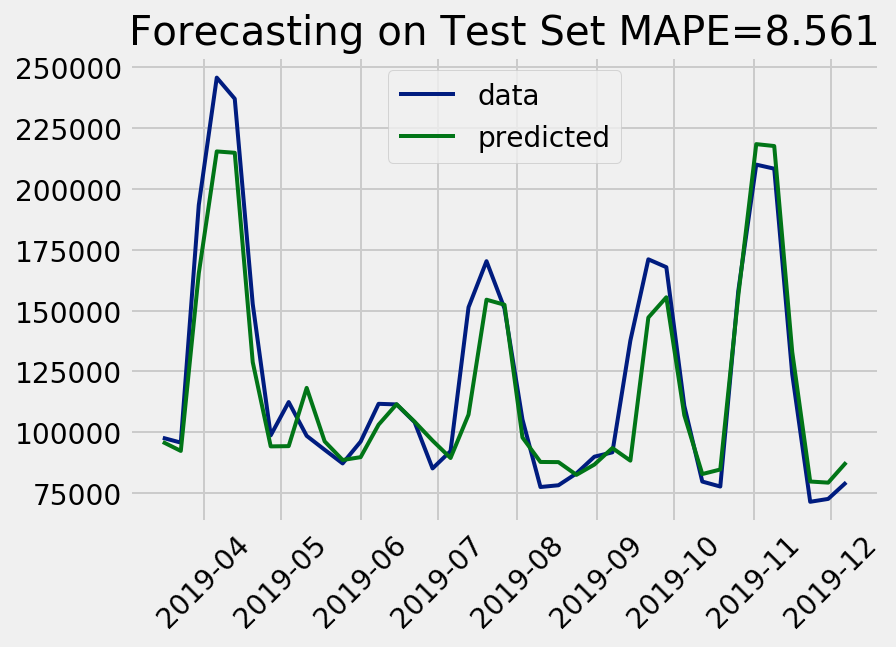

In [9]:
plot_results(y_test, pred_test, "target")  


In [10]:
# feature importance
print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
featureimp[:50]

Features Importance...


,feature,split,gain
11,log_price,40,68.653667
9,diff2,27,18.193183
3,sales_w-1,21,3.710550
8,diff1,29,3.400159
10,pdiff1,27,2.848483
4,dayofyear,14,0.754190
12,rolling2,27,0.664462
5,dayofmonth,21,0.605850
7,promo,10,0.332957
2,year,10,0.318316


In [11]:
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params = {'objective': 'reg:squarederror', 
          'eval_metric': 'rmsle',
          'eta': 0.01,
          'max_depth': 500, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.01,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=True, early_stopping_rounds = 100)
    
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit)
    
    return xgb_pred_y, model_xgb

In [12]:
# XGB
xreg = xgb.XGBRegressor(n_estimators=1000)
xreg.fit(dev_X, dev_y,
        eval_set=[(dev_X, dev_y), (val_X, val_y)],
        early_stopping_rounds=100,
       verbose=False)
pred_test_xgb = xreg.predict(X_test)
#pred_test_xgb, model_xgb = run_xgb(dev_X, dev_y, val_X, val_y, X_test)
print("XGB Training Completed...")

XGB Training Completed...


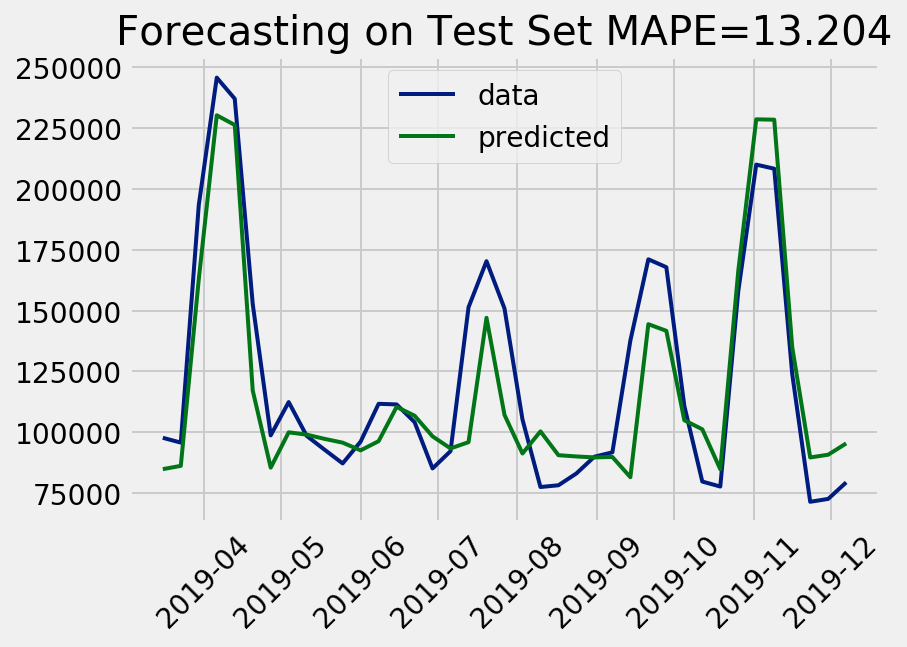

In [13]:
plot_results(y_test, pred_test_xgb, "target")  


In [14]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='MAPE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

In [15]:
cb_model.fit(dev_X, dev_y,
             eval_set=(val_X, val_y),
             use_best_model=True,
             verbose=50)

0:	learn: 0.3124044	test: 0.3363342	best: 0.3363342 (0)	total: 74ms	remaining: 36.9s
50:	learn: 0.0957337	test: 0.1818105	best: 0.1818105 (50)	total: 1.02s	remaining: 8.98s
100:	learn: 0.0429828	test: 0.1547543	best: 0.1547543 (100)	total: 2.62s	remaining: 10.4s
150:	learn: 0.0226506	test: 0.1498620	best: 0.1498620 (150)	total: 4.2s	remaining: 9.71s
200:	learn: 0.0119591	test: 0.1477749	best: 0.1477749 (200)	total: 5.71s	remaining: 8.49s
250:	learn: 0.0066086	test: 0.1468171	best: 0.1468171 (250)	total: 6.98s	remaining: 6.93s
300:	learn: 0.0036326	test: 0.1465412	best: 0.1464478 (285)	total: 8.07s	remaining: 5.33s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1464477924
bestIteration = 285

Shrink model to first 286 iterations.


In [16]:
pred_test_cat = cb_model.predict(X_test)

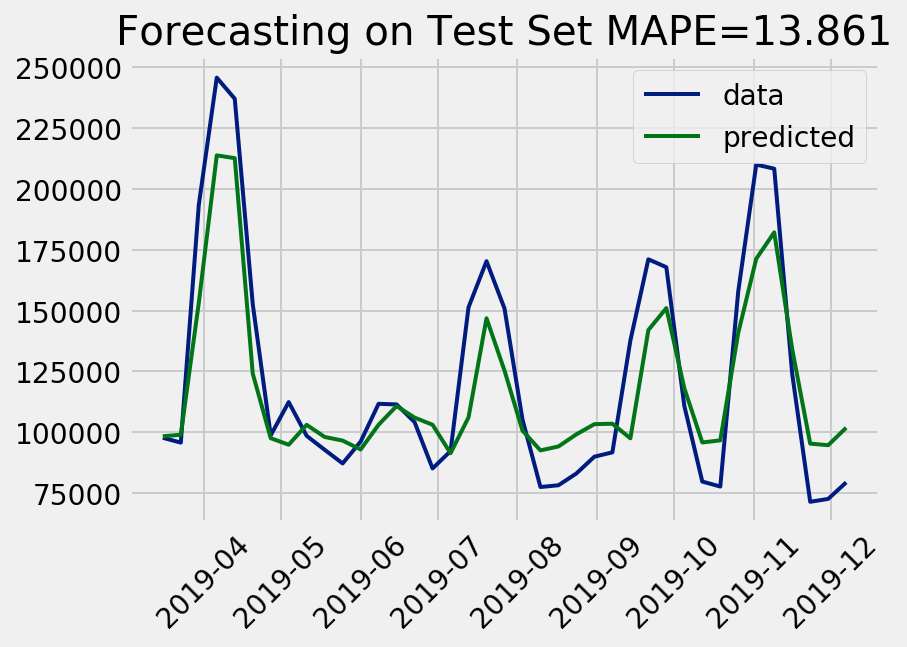

In [17]:
plot_results(y_test, pred_test_cat, "target")  


In [18]:
df_result_combined = pd.DataFrame(y_test)
df_result_combined.head()

,target
date,
2019-03-16,97762.0
2019-03-23,95792.0
2019-03-30,193324.0
2019-04-06,245623.0
2019-04-13,236954.0


In [19]:
forest = RandomForestRegressor(n_estimators=1000, random_state=123)
forest.fit(X_train, y_train)

forest_yt = forest.predict(X_train)
forest_yp = forest.predict(X_test)

print('RMSE on Test %.3f'%math.sqrt(mean_squared_error(y_test,forest_yp)))
mape = mean_absolute_percentage_error(y_test,forest_yp)
print('MAPE on Test %.3f'%mape)


RMSE on Test 20580.132
MAPE on Test 12.257


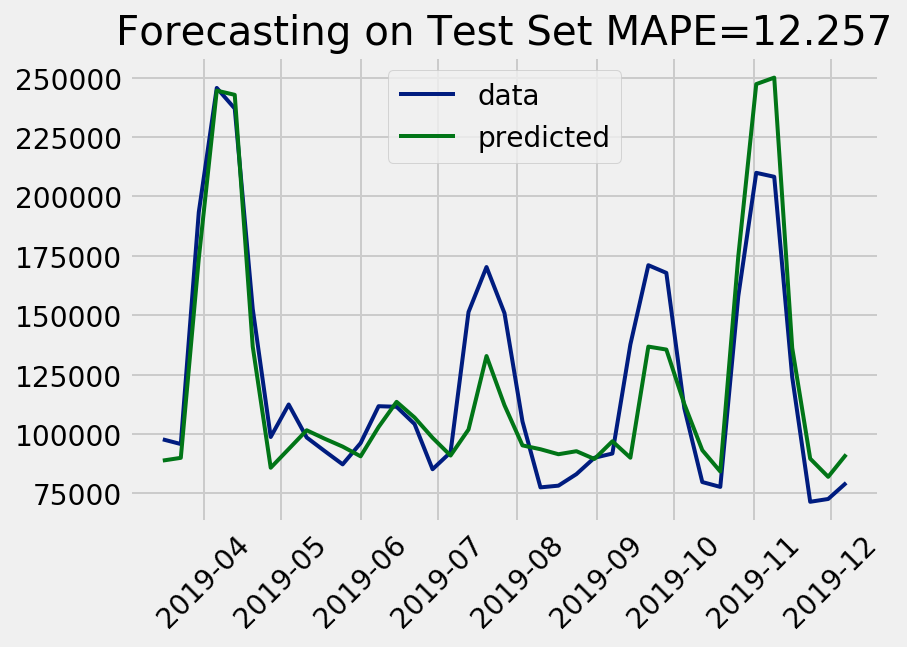

In [20]:
plot_results(y_test, forest_yp, "target")

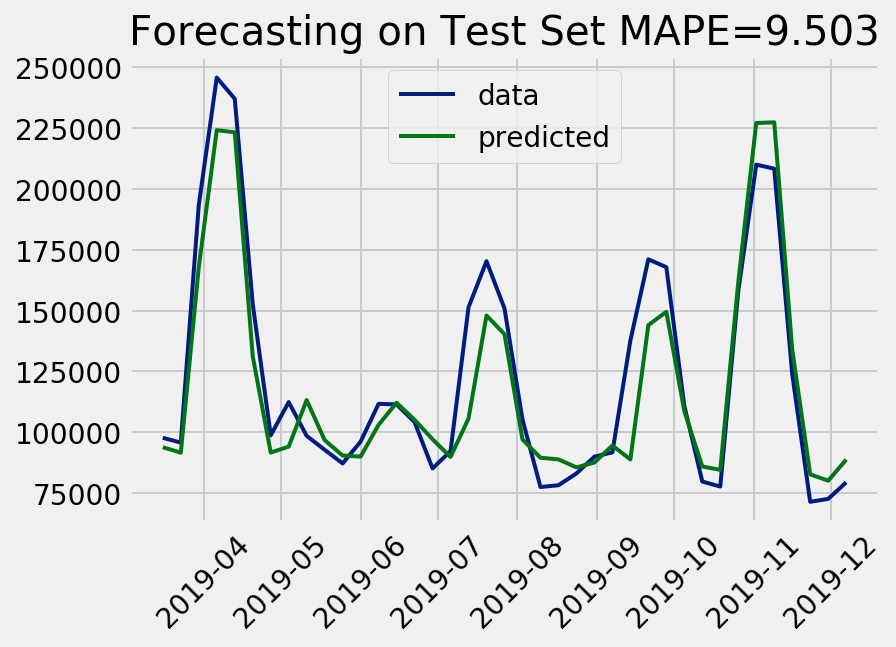

In [23]:
prediction = 0.7*pred_test +0.3*forest_yp #+ 0.6*pred_test_xgb
#prediction = 0.4*pred_test_xgb + 0.5*forest_yp + 0.1*pred_test

plot_results(df_result_combined, prediction, "target")  
